# 1. Importing modules and functions

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import MACCSkeys
import chembl_structure_pipeline
from molvs import standardize_smiles
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from numpy import savetxt
from padelpy import from_sdf
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

[09:54:00] Initializing Normalizer


# 2.Data entry and curation work set

In [2]:
uploaded_file_ws="datasets/HDAC3_work.sdf"
supplier_ws = Chem.ForwardSDMolSupplier(uploaded_file_ws,sanitize=False)
failed_mols_ws = []
all_mols_ws =[]
wrong_structure_ws=[]
wrong_smiles_ws=[]
y_tr = []
y_bad_index=[]

for i, m in enumerate(supplier_ws):
    structure = Chem.Mol(m)
    all_mols_ws.append(structure)
    y_tr.append(m.GetProp("pchembl_value_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ws.append(m)
        wrong_smiles_ws.append(Chem.MolToSmiles(m))
        wrong_structure_ws.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ws), 'molecules')
print('Failed data: ', len(failed_mols_ws), 'molecules')
number_ws =[]
for i in range(len(failed_mols_ws)):
        number_ws.append(str(i+1))
bad_molecules_ws = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ws, 'SMILES of wrong structure: ': wrong_smiles_ws, 'No.': number_ws}, index=None)
bad_molecules_ws = bad_molecules_ws.set_index('No.')
bad_molecules_ws

Original data:  1400 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [3]:
y_tr[:] = [x for i,x in enumerate(y_tr) if i not in y_bad_index]

In [4]:
len(y_tr)

1400

# 3.Standardization SDF file for work set

In [4]:
all_mols_ws[:] = [x for i,x in enumerate(all_mols_ws) if i not in y_bad_index] 
records = []
for i in range(len(all_mols_ws)):
    record = Chem.MolToSmiles(all_mols_ws[i])
    records.append(record)

moldf_ws = []
for i,record in enumerate(records):
    standard_record = standardize_smiles(record)
    m = Chem.MolFromSmiles(standard_record)
    moldf_ws.append(m)
    
print('Kept data: ', len(moldf_ws), 'molecules')

Kept data:  1400 molecules


In [5]:
moldf_ws

 ...]

In [6]:
moldf_ws=pd.DataFrame(moldf_ws, columns=['Mol'])
moldf_ws

,Mol
0,<rdkit.Chem.rdchem.Mol object at 0x000001CCC7C...
1,<rdkit.Chem.rdchem.Mol object at 0x000001CCC7A...
2,<rdkit.Chem.rdchem.Mol object at 0x000001CCC7C...
3,<rdkit.Chem.rdchem.Mol object at 0x000001CCC7C...
4,<rdkit.Chem.rdchem.Mol object at 0x000001CCC7C...
...,...
1395,<rdkit.Chem.rdchem.Mol object at 0x000001CCC9C...
1396,<rdkit.Chem.rdchem.Mol object at 0x000001CCC9C...
1397,<rdkit.Chem.rdchem.Mol object at 0x000001CCC9C...
1398,<rdkit.Chem.rdchem.Mol object at 0x000001CCC9C...


# 4.Data entry and curation test set

In [7]:
uploaded_file_ts="datasets/HDAC3_test.sdf"
supplier_ts = Chem.ForwardSDMolSupplier(uploaded_file_ts,sanitize=False)
failed_mols_ts = []
all_mols_ts =[]
wrong_structure_ts=[]
wrong_smiles_ts=[]
y_ts = []
y_bad_index=[]
for i, m in enumerate(supplier_ts):
    structure = Chem.Mol(m)
    all_mols_ts.append(structure)
    y_ts.append(m.GetProp("pchembl_value_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ts.append(m)
        wrong_smiles_ts.append(Chem.MolToSmiles(m))
        wrong_structure_ts.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ts), 'molecules')
print('Failed data: ', len(failed_mols_ts), 'molecules')
number_ts =[]
for i in range(len(failed_mols_ts)):
        number_ts.append(str(i+1))
bad_molecules_ts = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ts, 'SMILES of wrong structure: ': wrong_smiles_ts, 'No.': number_ts}, index=None)
bad_molecules_ts = bad_molecules_ts.set_index('No.')
bad_molecules_ts

Original data:  351 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [8]:
y_ts[:] = [x for i,x in enumerate(y_ts) if i not in y_bad_index]

In [9]:
len(y_ts)

351

# 5.Standardization SDF file for test set

In [10]:
all_mols_ts[:] = [x for i,x in enumerate(all_mols_ts) if i not in y_bad_index] 
records = []
for i in range(len(all_mols_ts)):
    record = Chem.MolToSmiles(all_mols_ts[i])
    records.append(record)

moldf_ts = []
for i,record in enumerate(records):
    standard_record = standardize_smiles(record)
    m = Chem.MolFromSmiles(standard_record)
    moldf_ts.append(m)
    
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  351 molecules


In [11]:
moldf_ts=pd.DataFrame(moldf_ts, columns=['Mol'])
moldf_ts

,Mol
0,<rdkit.Chem.rdchem.Mol object at 0x000001CCC7C...
1,<rdkit.Chem.rdchem.Mol object at 0x000001CCC7C...
2,<rdkit.Chem.rdchem.Mol object at 0x000001CCC7C...
3,<rdkit.Chem.rdchem.Mol object at 0x000001CCC7C...
4,<rdkit.Chem.rdchem.Mol object at 0x000001CCC7C...
...,...
346,<rdkit.Chem.rdchem.Mol object at 0x000001CCC7C...
347,<rdkit.Chem.rdchem.Mol object at 0x000001CCC7C...
348,<rdkit.Chem.rdchem.Mol object at 0x000001CCC7C...
349,<rdkit.Chem.rdchem.Mol object at 0x000001CCC7C...


# 6.Calculation MorganFingerprint for work set

In [14]:
def calcfp(mol):
    fp = MACCSkeys.GenMACCSKeys(mol)
    fp = pd.Series(np.asarray(fp))
    fp = fp.add_prefix('MACCS_')
    return fp

# Training set
desc_ws = moldf_ws.Mol.apply(calcfp)
desc_ws

,MACCS_0,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,MACCS_6,MACCS_7,MACCS_8,MACCS_9,...,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166
0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
1396,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
1397,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
1398,0,0,0,0,0,0,0,0,1,0,...,0,1,1,1,1,1,1,1,1,0


In [15]:
y_tr = np.array(y_tr, dtype=np.float32)
len(y_tr)

1400

# 7.Calculation MorganFingerprint for test set

In [16]:
desc_ts = moldf_ts.Mol.apply(calcfp)
desc_ts

,MACCS_0,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,MACCS_6,MACCS_7,MACCS_8,MACCS_9,...,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166
0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
347,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
348,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,0
349,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [18]:
y_ts = np.array(y_ts, dtype=np.float32)

# BASELINE

 ## GradientBoostingRegressor model building and validation

In [19]:
seed = 42

In [20]:
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [21]:
estimator = GradientBoostingRegressor(learning_rate=0.01,subsample= 0.5, n_estimators=1000, max_depth= 10,  random_state=seed)

In [22]:
estimator.fit(desc_ws, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [23]:
y_pred_CV_GBR = cross_val_predict(estimator, desc_ws, y_tr, cv=cv, n_jobs=-1)

In [24]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.65

In [25]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.72

# VarianceThreshold

In [26]:
from sklearn.feature_selection import VarianceThreshold

In [27]:
def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [28]:
x_tr_const_and_nearcont=variance_threshold_selector(desc_ws, 0.05)
x_tr_const_and_nearcont

,MACCS_22,MACCS_24,MACCS_25,MACCS_36,MACCS_38,MACCS_42,MACCS_47,MACCS_52,MACCS_53,MACCS_54,...,MACCS_148,MACCS_149,MACCS_150,MACCS_152,MACCS_153,MACCS_155,MACCS_157,MACCS_159,MACCS_160,MACCS_163
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
2,0,1,0,0,0,0,0,0,1,0,...,0,1,0,1,1,1,1,1,1,1
3,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,1,1
4,0,0,0,0,1,0,1,1,0,0,...,1,0,1,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,1,0,0,0,1,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
1396,1,0,0,0,1,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
1397,1,0,0,0,1,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
1398,0,0,0,0,1,1,0,0,0,1,...,1,0,1,1,1,1,0,1,1,1


In [29]:
estimator.fit(x_tr_const_and_nearcont, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [30]:
y_pred_CV_GBR = cross_val_predict(estimator, x_tr_const_and_nearcont, y_tr, cv=cv, n_jobs=-1)

In [31]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.65

In [32]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.72

# Removing highly correlated features

In [33]:
cor_df = x_tr_const_and_nearcont.corr().abs()
cor_df

,MACCS_22,MACCS_24,MACCS_25,MACCS_36,MACCS_38,MACCS_42,MACCS_47,MACCS_52,MACCS_53,MACCS_54,...,MACCS_148,MACCS_149,MACCS_150,MACCS_152,MACCS_153,MACCS_155,MACCS_157,MACCS_159,MACCS_160,MACCS_163
MACCS_22,1.000000e+00,0.111361,0.069495,0.025949,0.251526,0.098552,0.026649,0.092582,0.085509,0.125524,...,0.152283,0.134500,0.059369,0.155514,0.029650,0.104447,1.549118e-16,0.040112,0.021318,0.035424
MACCS_24,1.113610e-01,1.000000,0.237281,0.060409,0.146316,0.022141,0.003915,0.122035,0.093852,0.740671,...,0.004376,0.043961,0.265614,0.138344,0.282273,0.152637,3.303023e-02,0.280036,0.133635,0.015964
MACCS_25,6.949501e-02,0.237281,1.000000,0.169121,0.149929,0.140062,0.173473,0.028940,0.057241,0.239134,...,0.088413,0.131407,0.217936,0.196748,0.170159,0.426329,1.225379e-01,0.035932,0.145081,0.098620
MACCS_36,2.594892e-02,0.060409,0.169121,1.000000,0.100007,0.017776,0.806299,0.110711,0.006318,0.036380,...,0.224175,0.017826,0.083850,0.005468,0.046227,0.025296,3.422390e-02,0.011894,0.018388,0.442421
MACCS_38,2.515258e-01,0.146316,0.149929,0.100007,1.000000,0.051722,0.112364,0.050895,0.029222,0.187381,...,0.242715,0.105195,0.045799,0.133014,0.041552,0.121420,3.008198e-02,0.010319,0.109099,0.103901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MACCS_155,1.044466e-01,0.152637,0.426329,0.025296,0.121420,0.180555,0.082908,0.150420,0.108211,0.127351,...,0.085674,0.120242,0.144492,0.130717,0.481730,1.000000,1.171238e-01,0.111155,0.162047,0.071943
MACCS_157,1.549118e-16,0.033030,0.122538,0.034224,0.030082,0.117744,0.007603,0.135958,0.080418,0.032109,...,0.012261,0.325849,0.204798,0.676222,0.141949,0.117124,1.000000e+00,0.197588,0.291430,0.015778
MACCS_159,4.011192e-02,0.280036,0.035932,0.011894,0.010319,0.011741,0.043574,0.235365,0.071839,0.067741,...,0.117624,0.136963,0.028894,0.204201,0.097878,0.111155,1.975879e-01,1.000000,0.050761,0.049162
MACCS_160,2.131806e-02,0.133635,0.145081,0.018388,0.109099,0.207229,0.038071,0.010037,0.159957,0.034824,...,0.081905,0.613461,0.084064,0.360802,0.056347,0.162047,2.914303e-01,0.050761,1.000000,0.058099


In [34]:
cor_df = x_tr_const_and_nearcont.corr().abs()
cor_df

,MACCS_22,MACCS_24,MACCS_25,MACCS_36,MACCS_38,MACCS_42,MACCS_47,MACCS_52,MACCS_53,MACCS_54,...,MACCS_148,MACCS_149,MACCS_150,MACCS_152,MACCS_153,MACCS_155,MACCS_157,MACCS_159,MACCS_160,MACCS_163
MACCS_22,1.000000e+00,0.111361,0.069495,0.025949,0.251526,0.098552,0.026649,0.092582,0.085509,0.125524,...,0.152283,0.134500,0.059369,0.155514,0.029650,0.104447,1.549118e-16,0.040112,0.021318,0.035424
MACCS_24,1.113610e-01,1.000000,0.237281,0.060409,0.146316,0.022141,0.003915,0.122035,0.093852,0.740671,...,0.004376,0.043961,0.265614,0.138344,0.282273,0.152637,3.303023e-02,0.280036,0.133635,0.015964
MACCS_25,6.949501e-02,0.237281,1.000000,0.169121,0.149929,0.140062,0.173473,0.028940,0.057241,0.239134,...,0.088413,0.131407,0.217936,0.196748,0.170159,0.426329,1.225379e-01,0.035932,0.145081,0.098620
MACCS_36,2.594892e-02,0.060409,0.169121,1.000000,0.100007,0.017776,0.806299,0.110711,0.006318,0.036380,...,0.224175,0.017826,0.083850,0.005468,0.046227,0.025296,3.422390e-02,0.011894,0.018388,0.442421
MACCS_38,2.515258e-01,0.146316,0.149929,0.100007,1.000000,0.051722,0.112364,0.050895,0.029222,0.187381,...,0.242715,0.105195,0.045799,0.133014,0.041552,0.121420,3.008198e-02,0.010319,0.109099,0.103901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MACCS_155,1.044466e-01,0.152637,0.426329,0.025296,0.121420,0.180555,0.082908,0.150420,0.108211,0.127351,...,0.085674,0.120242,0.144492,0.130717,0.481730,1.000000,1.171238e-01,0.111155,0.162047,0.071943
MACCS_157,1.549118e-16,0.033030,0.122538,0.034224,0.030082,0.117744,0.007603,0.135958,0.080418,0.032109,...,0.012261,0.325849,0.204798,0.676222,0.141949,0.117124,1.000000e+00,0.197588,0.291430,0.015778
MACCS_159,4.011192e-02,0.280036,0.035932,0.011894,0.010319,0.011741,0.043574,0.235365,0.071839,0.067741,...,0.117624,0.136963,0.028894,0.204201,0.097878,0.111155,1.975879e-01,1.000000,0.050761,0.049162
MACCS_160,2.131806e-02,0.133635,0.145081,0.018388,0.109099,0.207229,0.038071,0.010037,0.159957,0.034824,...,0.081905,0.613461,0.084064,0.360802,0.056347,0.162047,2.914303e-01,0.050761,1.000000,0.058099


In [35]:
mask=np.triu(np.ones_like(cor_df, dtype=bool))

In [36]:
tri_df=cor_df.mask(mask)
tri_df

,MACCS_22,MACCS_24,MACCS_25,MACCS_36,MACCS_38,MACCS_42,MACCS_47,MACCS_52,MACCS_53,MACCS_54,...,MACCS_148,MACCS_149,MACCS_150,MACCS_152,MACCS_153,MACCS_155,MACCS_157,MACCS_159,MACCS_160,MACCS_163
MACCS_22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACCS_24,1.113610e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACCS_25,6.949501e-02,0.237281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACCS_36,2.594892e-02,0.060409,0.169121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MACCS_38,2.515258e-01,0.146316,0.149929,0.100007,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MACCS_155,1.044466e-01,0.152637,0.426329,0.025296,0.121420,0.180555,0.082908,0.150420,0.108211,0.127351,...,0.085674,0.120242,0.144492,0.130717,0.481730,NaN,NaN,NaN,NaN,NaN
MACCS_157,1.549118e-16,0.033030,0.122538,0.034224,0.030082,0.117744,0.007603,0.135958,0.080418,0.032109,...,0.012261,0.325849,0.204798,0.676222,0.141949,0.117124,NaN,NaN,NaN,NaN
MACCS_159,4.011192e-02,0.280036,0.035932,0.011894,0.010319,0.011741,0.043574,0.235365,0.071839,0.067741,...,0.117624,0.136963,0.028894,0.204201,0.097878,0.111155,0.197588,NaN,NaN,NaN
MACCS_160,2.131806e-02,0.133635,0.145081,0.018388,0.109099,0.207229,0.038071,0.010037,0.159957,0.034824,...,0.081905,0.613461,0.084064,0.360802,0.056347,0.162047,0.291430,0.050761,NaN,NaN


In [37]:
to_drop=[c for c in tri_df.columns if any(tri_df[c]>0.95) ]
to_drop

['MACCS_24',
 'MACCS_68',
 'MACCS_71',
 'MACCS_83',
 'MACCS_94',
 'MACCS_107',
 'MACCS_122',
 'MACCS_127']

In [38]:
reduced_df_cor=x_tr_const_and_nearcont.drop(to_drop, axis=1)

In [39]:
reduced_df_cor

,MACCS_22,MACCS_25,MACCS_36,MACCS_38,MACCS_42,MACCS_47,MACCS_52,MACCS_53,MACCS_54,MACCS_57,...,MACCS_148,MACCS_149,MACCS_150,MACCS_152,MACCS_153,MACCS_155,MACCS_157,MACCS_159,MACCS_160,MACCS_163
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
2,0,0,0,0,0,0,0,1,0,1,...,0,1,0,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,1,1
4,0,0,0,1,0,1,1,0,0,0,...,1,0,1,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,1,0,0,1,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
1396,1,0,0,1,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
1397,1,0,0,1,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
1398,0,0,0,1,1,0,0,0,1,1,...,1,0,1,1,1,1,0,1,1,1


In [40]:
estimator.fit(reduced_df_cor, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [41]:
y_pred_CV_GBR = cross_val_predict(estimator, reduced_df_cor, y_tr, cv=cv, n_jobs=-1)

In [42]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.64

In [43]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.73

In [44]:
feature_name_reduced_df_cor = reduced_df_cor.columns.tolist()
len(feature_name_reduced_df_cor)

89

# Prediction for test set's molecules

In [45]:
x_ts=desc_ts[feature_name_reduced_df_cor]

In [46]:
y_ts = np.array(y_ts, dtype=np.float32)

In [47]:
y_pred_GBR = estimator.predict(x_ts)

In [48]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.68

In [49]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.7

# Permutation-importance

In [52]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel

In [53]:
sel = SelectFromModel(PermutationImportance(GradientBoostingRegressor(), cv=cv),threshold=0.005,).fit(reduced_df_cor, y_tr)

In [54]:
X_permut_import = sel.transform(reduced_df_cor)
X_permut_import.shape

(1400, 30)

In [55]:
feature_idx = sel.get_support()
feature_name = reduced_df_cor.columns[feature_idx]
feature_name 

Index(['MACCS_22', 'MACCS_25', 'MACCS_38', 'MACCS_52', 'MACCS_53', 'MACCS_64',
       'MACCS_65', 'MACCS_69', 'MACCS_77', 'MACCS_80', 'MACCS_82', 'MACCS_87',
       'MACCS_90', 'MACCS_97', 'MACCS_99', 'MACCS_100', 'MACCS_105',
       'MACCS_108', 'MACCS_114', 'MACCS_115', 'MACCS_116', 'MACCS_123',
       'MACCS_130', 'MACCS_132', 'MACCS_136', 'MACCS_137', 'MACCS_144',
       'MACCS_146', 'MACCS_147', 'MACCS_163'],
      dtype='object')

In [56]:
estimator.fit(X_permut_import, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [57]:
y_pred_CV_GBR = cross_val_predict(estimator, X_permut_import, y_tr, cv=cv, n_jobs=-1)

In [58]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.58

In [59]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.79

# Prediction for test set's molecules

In [60]:
x_ts=desc_ts[feature_name]

In [61]:
y_ts = np.array(y_ts, dtype=np.float32)

In [62]:
y_pred_GBR = estimator.predict(x_ts)

In [63]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.61

In [64]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.76

 # Recursive feature elimination

In [65]:
from sklearn.feature_selection import RFECV
estimator

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [66]:
rfecv = RFECV(estimator=estimator, cv=cv, scoring='r2')
rfecv.fit(reduced_df_cor, y_tr)

RFECV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
      estimator=GradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                                          n_estimators=1000, random_state=42,
                                          subsample=0.5),
      scoring='r2')

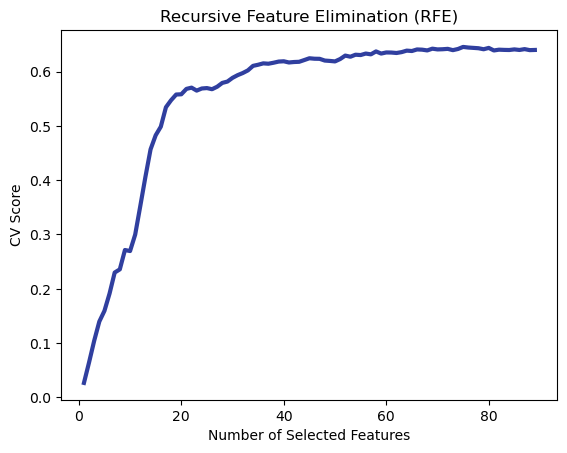

The optimal number of features: 75


In [67]:
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"], color='#303F9F', linewidth=3)
plt.xlabel("Number of Selected Features")
plt.ylabel("CV Score")
plt.title("Recursive Feature Elimination (RFE)")
plt.show()
print("The optimal number of features: {}".format(rfecv.n_features_))

Make a new DataFrame called "X_rfe" that contains selected features.

In [76]:
reduced_df_cor = np.array(reduced_df_cor, dtype=np.float32)

In [77]:
X_rfe = reduced_df_cor[:, rfecv.support_]

In [78]:
X_rfe.shape

(1400, 75)

In [71]:
estimator.fit(X_rfe, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [72]:
y_pred_CV_GBR = cross_val_predict(estimator, X_rfe, y_tr, cv=cv, n_jobs=-1)

In [73]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.65

In [74]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.72

In [80]:
reduced_df_cor=x_tr_const_and_nearcont.drop(to_drop, axis=1)

In [81]:
feature_idx = rfecv.get_support()
feature_name_rfecv = reduced_df_cor.columns[feature_idx]
feature_name_rfecv

Index(['MACCS_22', 'MACCS_38', 'MACCS_42', 'MACCS_47', 'MACCS_52', 'MACCS_53',
       'MACCS_54', 'MACCS_57', 'MACCS_62', 'MACCS_64', 'MACCS_65', 'MACCS_66',
       'MACCS_69', 'MACCS_72', 'MACCS_75', 'MACCS_77', 'MACCS_79', 'MACCS_80',
       'MACCS_82', 'MACCS_84', 'MACCS_85', 'MACCS_86', 'MACCS_87', 'MACCS_88',
       'MACCS_89', 'MACCS_90', 'MACCS_91', 'MACCS_93', 'MACCS_95', 'MACCS_96',
       'MACCS_97', 'MACCS_98', 'MACCS_99', 'MACCS_100', 'MACCS_101',
       'MACCS_105', 'MACCS_106', 'MACCS_108', 'MACCS_111', 'MACCS_112',
       'MACCS_114', 'MACCS_115', 'MACCS_116', 'MACCS_119', 'MACCS_120',
       'MACCS_123', 'MACCS_124', 'MACCS_125', 'MACCS_126', 'MACCS_128',
       'MACCS_129', 'MACCS_130', 'MACCS_132', 'MACCS_133', 'MACCS_135',
       'MACCS_136', 'MACCS_137', 'MACCS_138', 'MACCS_139', 'MACCS_140',
       'MACCS_141', 'MACCS_143', 'MACCS_144', 'MACCS_145', 'MACCS_146',
       'MACCS_147', 'MACCS_148', 'MACCS_149', 'MACCS_150', 'MACCS_152',
       'MACCS_153', 'MACCS_155',

In [82]:
desc_name_rfecv=list(feature_name_rfecv)

In [158]:
from pathlib import Path

In [161]:
urls=list(feature_name_rfecv)

In [162]:
path = Path('feature_name_rfecv_MCCS.txt')

In [163]:
path.write_text('\n'.join(urls))

716

# Prediction for test set's molecules

In [84]:
x_ts=desc_ts[feature_name_rfecv]

In [85]:
y_ts = np.array(y_ts, dtype=np.float32)

In [168]:
y_pred_GBR = estimator.predict(x_ts)

In [169]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.68

In [170]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.69

# save the model to disk

In [171]:
pickle.dump(estimator, open('Models/MACCS_FP/HDAC3_GBR_MACCS_final_FS.pkl', 'wb'))

# load the model from disk

In [167]:
best_GBR = pickle.load(open('Models/MACCS_FP/HDAC3_GBR_MACCS_final_FS.pkl', 'rb'))

# 10. Y-randomization model

In [92]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_GBR, X_rfe, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.6min


True score =  0.64 
Y-randomization =  -0.43 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.7min finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [93]:
neighbors_k= pairwise_distances(X_rfe, n_jobs=-1)
neighbors_k.sort(0)

In [94]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,1.000000,2.449490,1.414214,2.449490,2.828427,2.645751,1.732051,...,2.828427,1.732051,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,3.000000,0.000000
2,1.000000,0.000000,2.645751,2.000000,2.449490,2.645751,2.645751,3.000000,2.828427,2.449490,...,3.316625,2.449490,1.414214,1.000000,1.000000,1.000000,1.000000,0.000000,3.316625,0.000000
3,1.000000,0.000000,2.645751,2.449490,3.000000,3.162278,3.000000,3.000000,3.316625,2.645751,...,3.316625,2.645751,1.414214,1.000000,1.000000,1.000000,1.000000,1.000000,3.605551,1.732051
4,1.000000,1.000000,3.000000,2.645751,3.464102,3.162278,3.000000,3.162278,3.464102,2.645751,...,3.316625,3.162278,1.414214,1.000000,1.000000,1.000000,1.000000,1.000000,3.741657,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,6.708204,6.708204,6.855655,6.782330,6.633250,7.000000,6.782330,6.403124,7.071068,6.480741,...,6.557438,6.708204,7.141428,7.000000,7.141428,7.280110,7.141428,7.211102,7.000000,7.280110
1396,6.855655,6.708204,6.928203,6.782330,6.633250,7.000000,6.782330,6.480741,7.071068,6.480741,...,6.557438,6.708204,7.141428,7.000000,7.141428,7.280110,7.141428,7.211102,7.000000,7.280110
1397,6.855655,6.708204,6.928203,6.782330,6.708204,7.071068,6.855655,6.480741,7.071068,6.480741,...,6.633250,6.708204,7.141428,7.071068,7.211102,7.348469,7.211102,7.280110,7.071068,7.280110
1398,6.855655,6.782330,7.000000,6.855655,6.708204,7.141428,6.855655,6.480741,7.141428,6.633250,...,6.633250,6.782330,7.141428,7.071068,7.280110,7.416198,7.280110,7.348469,7.071068,7.416198


In [95]:
similarity= neighbors_k

In [96]:
Dmean=np.mean(similarity[1,:])

In [97]:
round(Dmean, 2)

1.31

In [98]:
std=np.std(similarity[1,:])

In [99]:
round(std, 2)

1.07

In [100]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

1.84


In [101]:
x_ts=desc_ts[feature_name_rfecv]

In [102]:
neighbors_k_ts= pairwise_distances(X_rfe,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [103]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,341,342,343,344,345,346,347,348,349,350
0,0.000000,2.449490,4.000000,2.000000,1.000000,2.000000,2.449490,1.414214,2.449490,2.449490,...,0.000000,2.645751,1.732051,1.414214,0.000000,0.000000,1.414214,0.000000,2.000000,1.000000
1,0.000000,3.741657,4.123106,2.236068,2.236068,2.236068,2.645751,1.414214,2.645751,2.449490,...,1.000000,2.645751,2.000000,1.732051,0.000000,0.000000,1.414214,1.000000,2.000000,1.414214
2,0.000000,3.872983,4.123106,2.449490,2.449490,3.000000,2.828427,1.732051,2.828427,2.645751,...,2.449490,2.828427,2.000000,1.732051,0.000000,0.000000,1.732051,1.000000,2.236068,2.000000
3,1.000000,3.872983,4.123106,2.645751,3.162278,3.000000,3.464102,2.449490,3.000000,2.645751,...,2.449490,2.828427,2.236068,1.732051,1.732051,1.000000,1.732051,1.000000,2.236068,2.000000
4,1.000000,3.872983,4.123106,2.645751,4.000000,3.162278,3.464102,2.645751,3.162278,2.828427,...,2.645751,3.000000,3.000000,1.732051,2.000000,1.000000,1.732051,1.000000,2.236068,2.236068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,6.708204,6.633250,6.557439,6.480741,7.000000,7.000000,7.141428,7.071068,6.633250,7.141428,...,6.557439,6.480741,6.633250,7.416198,7.280110,7.348469,7.141428,6.855655,7.000000,6.708204
1396,6.782330,6.633250,6.557439,6.480741,7.000000,7.000000,7.141428,7.071068,6.633250,7.141428,...,6.633250,6.480741,6.708204,7.416198,7.280110,7.348469,7.141428,6.928203,7.000000,6.708204
1397,6.782330,6.708204,6.633250,6.633250,7.071068,7.000000,7.141428,7.071068,6.633250,7.141428,...,6.633250,6.557439,6.708204,7.483315,7.280110,7.416198,7.141428,6.928203,7.071068,6.708204
1398,6.855655,6.708204,6.633250,6.633250,7.071068,7.000000,7.141428,7.071068,6.708204,7.211103,...,6.708204,6.557439,6.782330,7.549834,7.416198,7.483315,7.141428,7.071068,7.141428,6.782330


In [104]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[0.    2.449 4.    2.    1.    2.    2.449 1.414 2.449 2.449 2.236 1.414
 3.464 2.236 2.646 1.    0.    1.414 2.236 2.236 1.    3.    2.    0.
 1.414 1.    1.    0.    1.    1.    3.    1.    2.236 1.414 1.414 1.
 2.    1.414 1.414 2.449 2.646 2.828 2.236 2.828 1.732 1.732 2.236 2.
 1.    1.    2.236 1.414 1.732 0.    1.    3.464 1.    0.    0.    0.
 0.    1.    2.449 3.742 3.162 0.    2.828 2.    0.    2.236 2.236 1.
 1.732 1.414 1.414 0.    1.732 1.    1.732 1.    0.    1.    1.732 0.
 2.236 0.    1.414 1.    0.    3.317 1.    3.464 1.414 2.236 0.    2.449
 1.    0.    0.    1.    3.742 1.414 2.646 0.    1.    0.    2.    0.
 1.414 0.    0.    1.414 1.414 0.    2.449 1.    1.    1.    1.732 1.
 3.    1.414 2.828 1.732 1.    2.646 1.414 1.414 1.    1.    1.414 2.449
 1.    0.    1.414 0.    0.    0.    3.464 1.    3.    1.    1.414 2.449
 0.    1.414 1.    1.    1.414 2.449 2.449 1.414 0.    0.    0.    2.
 1.414 2.236 1.    1.414 2.449 0.    0.    2.236 0.    1.414 1.732 0.
 1.414 1

In [105]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True False False False  True False False  True False False False  True
 False False False  True  True  True False False  True False False  True
  True  True  True  True  True  True False  True False  True  True  True
 False  True  True False False False False False  True  True False False
  True  True False  True  True  True  True False  True  True  True  True
  True  True False False False  True False False  True False False  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True False  True False  True False  True False
  True  True  True  True False  True False  True  True  True False  True
  True  True  True  True  True  True False  True  True  True  True  True
 False  True False  True  True False  True  True  True  True  True False
  True  True  True  True  True  True False  True False  True  True False
  True  True  True  True  True False False  True  True  True  True False
  True False  True  True False  True  True False  T

In [106]:
print("Coverage = ", sum(cpd_AD) / len(cpd_AD))

Coverage =  0.7236467236467237


In [107]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  0   4   7  11  15  16  17  20  23  24  25  26  27  28  29  31  33  34
  35  37  38  44  45  48  49  51  52  53  54  56  57  58  59  60  61  65
  68  71  72  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88
  90  92  94  96  97  98  99 101 103 104 105 107 108 109 110 111 112 113
 115 116 117 118 119 121 123 124 126 127 128 129 130 132 133 134 135 136
 137 139 141 142 144 145 146 147 148 151 152 153 154 156 158 159 161 162
 164 165 166 167 168 169 170 171 172 173 174 177 178 179 180 183 184 185
 186 187 188 189 190 191 192 193 196 197 198 199 201 202 203 204 206 207
 208 209 210 211 213 214 215 216 217 218 220 221 222 223 226 227 228 230
 231 232 233 234 235 237 238 239 240 242 244 245 246 247 249 250 251 252
 253 254 255 256 257 258 259 261 263 264 266 267 268 269 270 271 272 275
 277 280 281 282 283 284 285 286 287 289 291 294 297 298 299 300 301 303
 304 306 307 308 312 313 315 316 317 319 320 321 322 323 324 325 326 327
 328 329 33

In [108]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [109]:
y_pred_GBR_ad=list(y_pred_GBR)

In [110]:
y_pred_GBR_ad[:] = [x for i,x in enumerate(y_pred_GBR_ad) if i not in out_Ad]

In [111]:
len(y_pred_GBR_ad)

254

In [112]:
y_ts_ad=list(y_ts)

In [113]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [114]:
len(y_ts_ad)

254

In [115]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_GBR_ad), 2)
Q2_TS

0.73

In [116]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_GBR_ad)), 2)
RMSE_TS

0.62

# SVM model building and validation

In [117]:
from sklearn.svm import SVR

In [118]:
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [119]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [120]:
svm = GridSearchCV(SVR(C=1.0, epsilon=0.2), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [121]:
svm.fit(X_rfe, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVR(epsilon=0.2), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [122]:
svm.best_params_
best_svm = svm.best_estimator_

In [123]:
svm.best_params_

{'C': 10, 'gamma': 0.1}

In [124]:
y_pred_CV_svm = cross_val_predict(best_svm, X_rfe, y_tr, cv=cv)

In [125]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_svm), 2)
Q2_CV

0.65

In [126]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_svm)), 2)
RMSE_CV

0.72

#  Prediction for test set's molecules

In [127]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [128]:
y_pred_svm = best_svm.predict(x_ts)

In [129]:
Q2_TS = round(r2_score(y_ts, y_pred_svm), 2)
Q2_TS

0.68

In [130]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_svm)), 2)
RMSE_TS

0.69

save the model to disk

In [172]:
pickle.dump(best_svm, open('Models/MACCS_FP/HDAC3_SVM_MACCS_FP.pkl', 'wb'))

load the model from disk

In [132]:
best_svm = pickle.load(open('Models/MACCS_FP/HDAC3_SVM_MACCS_FP.pkl', 'rb'))

# 10. Y-randomization SVM model

In [133]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_svm, X_rfe, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(3),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.6s


True score =  0.643 
Y-randomization =  -0.38 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.7s finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [134]:
neighbors_k= pairwise_distances(X_rfe, n_jobs=-1)
neighbors_k.sort(0)

In [135]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,1.000000,2.449490,1.414214,2.449490,2.828427,2.645751,1.732051,...,2.828427,1.732051,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,3.000000,0.000000
2,1.000000,0.000000,2.645751,2.000000,2.449490,2.645751,2.645751,3.000000,2.828427,2.449490,...,3.316625,2.449490,1.414214,1.000000,1.000000,1.000000,1.000000,0.000000,3.316625,0.000000
3,1.000000,0.000000,2.645751,2.449490,3.000000,3.162278,3.000000,3.000000,3.316625,2.645751,...,3.316625,2.645751,1.414214,1.000000,1.000000,1.000000,1.000000,1.000000,3.605551,1.732051
4,1.000000,1.000000,3.000000,2.645751,3.464102,3.162278,3.000000,3.162278,3.464102,2.645751,...,3.316625,3.162278,1.414214,1.000000,1.000000,1.000000,1.000000,1.000000,3.741657,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,6.708204,6.708204,6.855655,6.782330,6.633250,7.000000,6.782330,6.403124,7.071068,6.480741,...,6.557438,6.708204,7.141428,7.000000,7.141428,7.280110,7.141428,7.211102,7.000000,7.280110
1396,6.855655,6.708204,6.928203,6.782330,6.633250,7.000000,6.782330,6.480741,7.071068,6.480741,...,6.557438,6.708204,7.141428,7.000000,7.141428,7.280110,7.141428,7.211102,7.000000,7.280110
1397,6.855655,6.708204,6.928203,6.782330,6.708204,7.071068,6.855655,6.480741,7.071068,6.480741,...,6.633250,6.708204,7.141428,7.071068,7.211102,7.348469,7.211102,7.280110,7.071068,7.280110
1398,6.855655,6.782330,7.000000,6.855655,6.708204,7.141428,6.855655,6.480741,7.141428,6.633250,...,6.633250,6.782330,7.141428,7.071068,7.280110,7.416198,7.280110,7.348469,7.071068,7.416198


In [136]:
similarity= neighbors_k

In [137]:
Dmean=np.mean(similarity[1,:])

In [138]:
round(Dmean, 2)

1.31

In [139]:
std=np.std(similarity[1,:])

In [140]:
round(std, 2)

1.07

In [141]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

1.84


In [142]:
x_ts=desc_ts[feature_name_rfecv]

In [143]:
neighbors_k_ts= pairwise_distances(X_rfe,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [144]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,341,342,343,344,345,346,347,348,349,350
0,0.000000,2.449490,4.000000,2.000000,1.000000,2.000000,2.449490,1.414214,2.449490,2.449490,...,0.000000,2.645751,1.732051,1.414214,0.000000,0.000000,1.414214,0.000000,2.000000,1.000000
1,0.000000,3.741657,4.123106,2.236068,2.236068,2.236068,2.645751,1.414214,2.645751,2.449490,...,1.000000,2.645751,2.000000,1.732051,0.000000,0.000000,1.414214,1.000000,2.000000,1.414214
2,0.000000,3.872983,4.123106,2.449490,2.449490,3.000000,2.828427,1.732051,2.828427,2.645751,...,2.449490,2.828427,2.000000,1.732051,0.000000,0.000000,1.732051,1.000000,2.236068,2.000000
3,1.000000,3.872983,4.123106,2.645751,3.162278,3.000000,3.464102,2.449490,3.000000,2.645751,...,2.449490,2.828427,2.236068,1.732051,1.732051,1.000000,1.732051,1.000000,2.236068,2.000000
4,1.000000,3.872983,4.123106,2.645751,4.000000,3.162278,3.464102,2.645751,3.162278,2.828427,...,2.645751,3.000000,3.000000,1.732051,2.000000,1.000000,1.732051,1.000000,2.236068,2.236068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,6.708204,6.633250,6.557439,6.480741,7.000000,7.000000,7.141428,7.071068,6.633250,7.141428,...,6.557439,6.480741,6.633250,7.416198,7.280110,7.348469,7.141428,6.855655,7.000000,6.708204
1396,6.782330,6.633250,6.557439,6.480741,7.000000,7.000000,7.141428,7.071068,6.633250,7.141428,...,6.633250,6.480741,6.708204,7.416198,7.280110,7.348469,7.141428,6.928203,7.000000,6.708204
1397,6.782330,6.708204,6.633250,6.633250,7.071068,7.000000,7.141428,7.071068,6.633250,7.141428,...,6.633250,6.557439,6.708204,7.483315,7.280110,7.416198,7.141428,6.928203,7.071068,6.708204
1398,6.855655,6.708204,6.633250,6.633250,7.071068,7.000000,7.141428,7.071068,6.708204,7.211103,...,6.708204,6.557439,6.782330,7.549834,7.416198,7.483315,7.141428,7.071068,7.141428,6.782330


In [145]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[0.    2.449 4.    2.    1.    2.    2.449 1.414 2.449 2.449 2.236 1.414
 3.464 2.236 2.646 1.    0.    1.414 2.236 2.236 1.    3.    2.    0.
 1.414 1.    1.    0.    1.    1.    3.    1.    2.236 1.414 1.414 1.
 2.    1.414 1.414 2.449 2.646 2.828 2.236 2.828 1.732 1.732 2.236 2.
 1.    1.    2.236 1.414 1.732 0.    1.    3.464 1.    0.    0.    0.
 0.    1.    2.449 3.742 3.162 0.    2.828 2.    0.    2.236 2.236 1.
 1.732 1.414 1.414 0.    1.732 1.    1.732 1.    0.    1.    1.732 0.
 2.236 0.    1.414 1.    0.    3.317 1.    3.464 1.414 2.236 0.    2.449
 1.    0.    0.    1.    3.742 1.414 2.646 0.    1.    0.    2.    0.
 1.414 0.    0.    1.414 1.414 0.    2.449 1.    1.    1.    1.732 1.
 3.    1.414 2.828 1.732 1.    2.646 1.414 1.414 1.    1.    1.414 2.449
 1.    0.    1.414 0.    0.    0.    3.464 1.    3.    1.    1.414 2.449
 0.    1.414 1.    1.    1.414 2.449 2.449 1.414 0.    0.    0.    2.
 1.414 2.236 1.    1.414 2.449 0.    0.    2.236 0.    1.414 1.732 0.
 1.414 1

In [146]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True False False False  True False False  True False False False  True
 False False False  True  True  True False False  True False False  True
  True  True  True  True  True  True False  True False  True  True  True
 False  True  True False False False False False  True  True False False
  True  True False  True  True  True  True False  True  True  True  True
  True  True False False False  True False False  True False False  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True False  True False  True False  True False
  True  True  True  True False  True False  True  True  True False  True
  True  True  True  True  True  True False  True  True  True  True  True
 False  True False  True  True False  True  True  True  True  True False
  True  True  True  True  True  True False  True False  True  True False
  True  True  True  True  True False False  True  True  True  True False
  True False  True  True False  True  True False  T

In [147]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.72


In [148]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  0   4   7  11  15  16  17  20  23  24  25  26  27  28  29  31  33  34
  35  37  38  44  45  48  49  51  52  53  54  56  57  58  59  60  61  65
  68  71  72  73  74  75  76  77  78  79  80  81  82  83  85  86  87  88
  90  92  94  96  97  98  99 101 103 104 105 107 108 109 110 111 112 113
 115 116 117 118 119 121 123 124 126 127 128 129 130 132 133 134 135 136
 137 139 141 142 144 145 146 147 148 151 152 153 154 156 158 159 161 162
 164 165 166 167 168 169 170 171 172 173 174 177 178 179 180 183 184 185
 186 187 188 189 190 191 192 193 196 197 198 199 201 202 203 204 206 207
 208 209 210 211 213 214 215 216 217 218 220 221 222 223 226 227 228 230
 231 232 233 234 235 237 238 239 240 242 244 245 246 247 249 250 251 252
 253 254 255 256 257 258 259 261 263 264 266 267 268 269 270 271 272 275
 277 280 281 282 283 284 285 286 287 289 291 294 297 298 299 300 301 303
 304 306 307 308 312 313 315 316 317 319 320 321 322 323 324 325 326 327
 328 329 33

In [149]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [150]:
y_pred_svm_ad=list(y_pred_svm)

In [151]:
y_pred_svm_ad[:] = [x for i,x in enumerate(y_pred_svm_ad) if i not in out_Ad]

In [152]:
len(y_pred_svm_ad)

254

In [153]:
y_ts_ad=list(y_ts)

In [154]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [155]:
len(y_ts_ad)

254

In [156]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_svm_ad), 2)
Q2_TS

0.74

In [157]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_svm_ad)), 2)
RMSE_TS

0.61